### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting

from skopt.space import Categorical, Integer, Real 

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'mean_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory already exsist!
Directory already exsist!


In [4]:
for i in ['RandomForest_Cog', 'SVM_poly_Cog', 'XGBoost_Cog']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory created!
Directory created!
Directory created!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
cols =  ['site', 'id','diagnosis', 'year_birth', 'sex', 'years_education', 'ifs_total_score', 'mini_sea_total',
 'npi_total', 'npi_total_caregiver', 'cognition', 'functionality', 'marital_status',
 'n_children', 'household_members', 'household_income', 'Job_status', 'strata']

In [7]:
# test[cols].dropna()

In [8]:
def impute_mean(group):
    return group.fillna(group.mean())

nan_cols = train.isna().sum()[train.isna().sum()>0].index.tolist()

for i in nan_cols:
    train[i] = train[i].transform(impute_mean)
    
nan_cols = test.isna().sum()[test.isna().sum()>0].index.tolist()

for i in nan_cols:
    test[i] = test[i].fillna(test[i].mean())

train = train[cols].dropna()
test = test[cols].dropna()

In [9]:
# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
#               'mini_sea_total', 'barthel_total', 'pfeffer_total',  'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition', 'functionality',
#               'marital_status', 'n_children', 'household_members', 'household_income', 'Job_status',
#               'income_s_NaN', 'income_s_1', 'income_s_2', 'income_s_3', 'income_s_4', 'income_s_5',
#               'income_s_6', 'income_s_7','income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata']

# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
#               'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw','ace_vs', 'ace_lw', 'barthel_total',
#               'pfeffer_total','cognition', 'functionality', 'marital_status', 'n_children',
#               'household_members', 'household_income', 'Job_status', 'strata']

# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
#               'mini_sea_total', 'npi_total', 'npi_total_caregiver', 'mmse_vs', 'moca_vs','ace_vs',
#               'functionality', 'marital_status', 'n_children', 'household_members', 'household_income',
#               'Job_status', 'strata']

# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education','ifs_total_score',
#               'mini_sea_total', 'npi_total', 'cognition',  'functionality', 'strata']
final_cols = ['site', 'id','diagnosis', 'year_birth', 'sex', 'years_education', 'ifs_total_score', 'mini_sea_total',
 'npi_total', 'npi_total_caregiver', 'cognition', 'functionality', 'marital_status',
 'n_children', 'household_members', 'household_income', 'Job_status', 'strata']


train = train[final_cols]
test = test[final_cols]
    
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

In [10]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
       'cognition', 'functionality', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'strata'],
      dtype='object')

In [11]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and FTD
data = train.query("diagnosis != 'CN'")
data['diagnosis'] = data['diagnosis'].replace({'AD':0, 'FTD':1})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'CN'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':0, 'FTD':1})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

train.shape, test.shape

((1450, 15), (161, 15))

In [12]:
#### Librerías 
# cambiamos el dir de trabajo
os.chdir("/home/marcelo/GitRepos/Tesis/code") # desktop
# os.chdir("/home/mm/Tesis/code") # ssh

In [13]:
### Load Hyperparams
# hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-09-23/mean_hparams/"
# xgb_hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-11-07/mean_hparams/" # Desktop
hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-11-25/mean_hparams/"


rf_hp = pd.read_csv(hparams_path + "RF_hparams_fcols3.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp= rf_hp[rf_hp['mean_test_score'] < rf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

# poly_hp = pd.read_csv(hparams_path + "SVC_Poly_hparams.csv",
#                       usecols=['param_C', 'param_coef0', 'param_degree','param_gamma','params', 
#                                'mean_test_score' ,'mean_train_score'])
# poly_hp= poly_hp[poly_hp['mean_test_score'] < poly_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

# xgb_hp = pd.read_csv(hparams_path + "xgb_hparams.csv", usecols=['param_learning_rate',
#        'param_max_depth', 'param_n_estimators', 'param_colsample_bytree','param_min_child_weight',
#         'params', 'mean_test_score' ,'mean_train_score'])
# xgb_hp= xgb_hp[xgb_hp['mean_test_score'] < xgb_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

In [14]:
rf_row = 0
rf_hp.iloc[rf_row,:]

param_criterion                                                         gini
param_max_depth                                                            6
param_max_features                                                         5
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                       500
params                     OrderedDict([('criterion', 'gini'), ('max_dept...
mean_test_score                                                     0.863213
mean_train_score                                                    0.945054
Name: 0, dtype: object

In [15]:
# poly_row = 0
# poly_hp.iloc[0,: ]

In [16]:
# xgb_row=0
# xgb_hp.iloc[0, :]

In [17]:
## Models Hparams
# RF
rf_params= {"n_estimators": rf_hp.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

# #Poly
# poly_params = {'C': poly_hp.loc[poly_row, "param_C"],
#               'gamma': poly_hp.loc[poly_row, "param_gamma"],
#                'coef0': poly_hp.loc[poly_row, "param_coef0"],
#                'degree': poly_hp.loc[poly_row, 'param_degree'],
#               "kernel":"poly","class_weight":"balanced", "verbose":0, 'max_iter':10**6}

# #XGBOOST
# xgb_params = {
#     'max_depth': xgb_hp.loc[xgb_row, 'param_max_depth'],
#     'learning_rate': xgb_hp.loc[xgb_row, 'param_learning_rate'],
#     'n_estimators': xgb_hp.loc[xgb_row, 'param_n_estimators'],
#     'colsample_bytree': xgb_hp.loc[xgb_row, 'param_colsample_bytree'],
#     'min_child_weight': xgb_hp.loc[xgb_row, 'param_min_child_weight'],
#     'gamma': 1,
#     'subsample':1.0,
# #     'enable_categorical':True, # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
#     'n_jobs': -1,
#     'verbosity':0,
#     'eval_metric':'auc',
#     'objective':'binary:logistic',
#     'use_label_encoder':None}

# # xgb_params ={'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'gamma': 0.8045117829208245,
# #              'learning_rate': 0.06547359028644324, 'max_depth': 4, 'n_estimators': 100,
# #              'objective': 'binary:logistic', 'reg_alpha': 0.0, 'reg_lambda': 0.9798465147079346,
# #              'subsample': 0.8,'n_jobs': -1,'verbosity':0}

In [18]:
n_iter = 5000

### Base model: Logistic Regression

In [19]:
lr_res, lr_CI_df, lr_res_r, lr_ROC_AUC, lr_CM, lr_ROC_chance, lr_empirical_p_value = bc.Bootstrap_linear_classifier(
    data, 'diagnosis', LogisticRegression(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

LogisticRegression()


Iterating: 100%|██████████████████| 5000/5000 [03:36<00:00, 23.10it/s]


singular_matrix_errors (droped from results): 0
Eleapsed time:3.608066395918528 minutes
empirical p-value: 0.0


In [20]:
lr_res.mean()

Accuracy         0.810758
ROC_AUC          0.816367
Precision        0.769981
Recall           0.286361
Sensitivity      0.286361
Specificity      0.972652
F1               0.413771
Efron_pR2        0.239268
mcfadden_pR2     0.368577
mcfadden_apR2    0.317916
dtype: float64

In [21]:
lr_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci,mcfadden_pR2_ci,mcfadden_apR2_ci
0,0.010857,0.010732,0.011665,0.01253,0.01253,0.004521,0.013652,0.011826,0.013372,0.012908


In [22]:
lr_res_r.head()

,variables,coef_mean,coef_std,T_mean,T_std,p_val_mean,p_val_std
0,Job_status,-0.359739,0.159764,-2.299205,1.030549,0.123494,0.185338
1,cognition,1.136338,0.194020,6.038196,1.090574,0.000017,0.000397
2,functionality,0.030092,0.197118,0.136466,0.911867,0.997528,0.001758
3,household_income,-0.393331,0.177550,-1.480017,0.681103,0.345767,0.170672
4,household_members,-0.229214,0.151860,-0.493785,0.335436,0.989164,0.002086


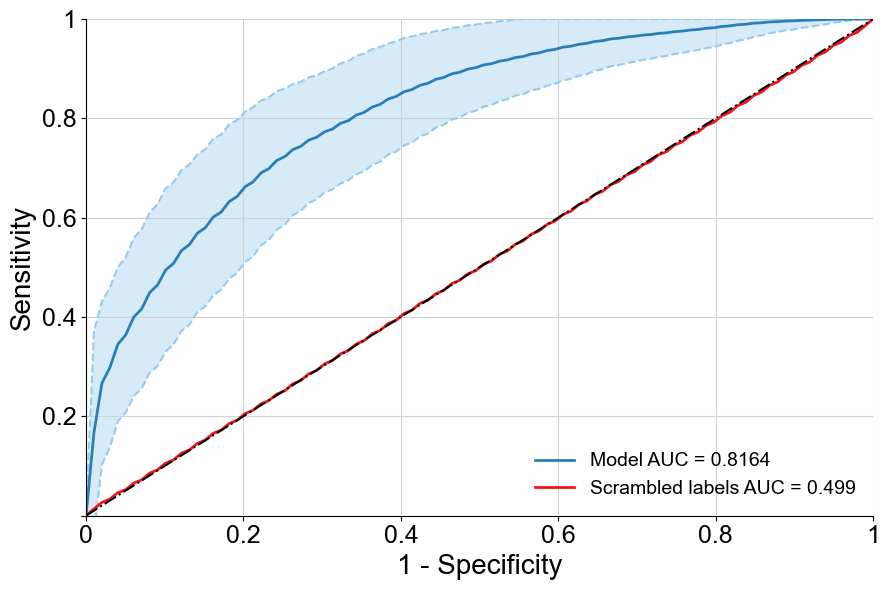

In [23]:
ml_plotting.plot_custom_roc_curve(lr_ROC_AUC, lr_ROC_chance, fname=None)

In [24]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', LogisticRegression(), params='default', test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [25]:
# rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

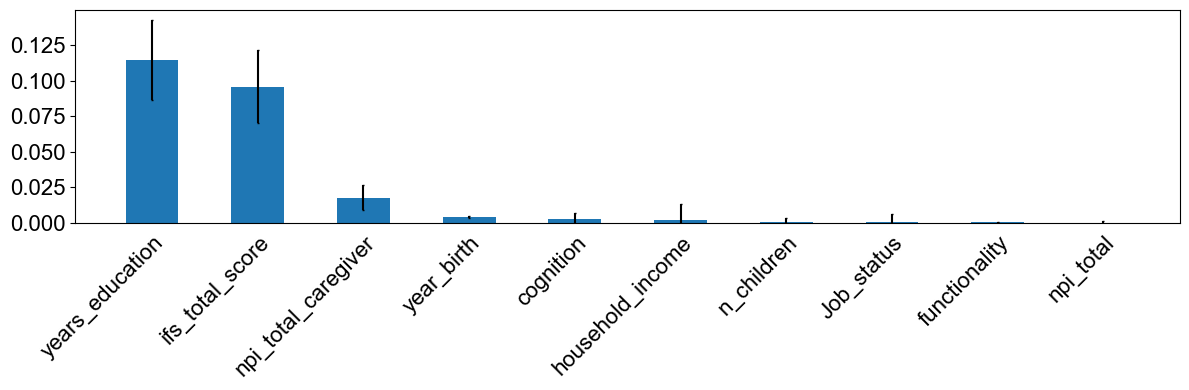

In [26]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

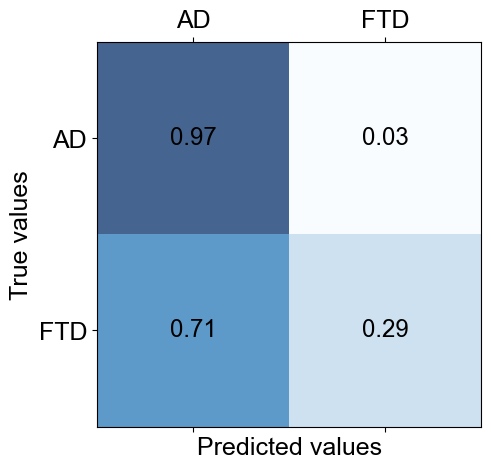

In [27]:
ml_plotting.plot_boostrap_CM(lr_CM, labels=['AD', 'FTD'],fname=None)

#### unseen data

In [28]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [29]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [30]:
# predict & scores
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [31]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [32]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.5817
Accuracy: 0.785
Recall: 0.2
F1: 0.303
Precision:0.625


In [33]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lr_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.5817
Bootstrping test ROC score: 	0.8164


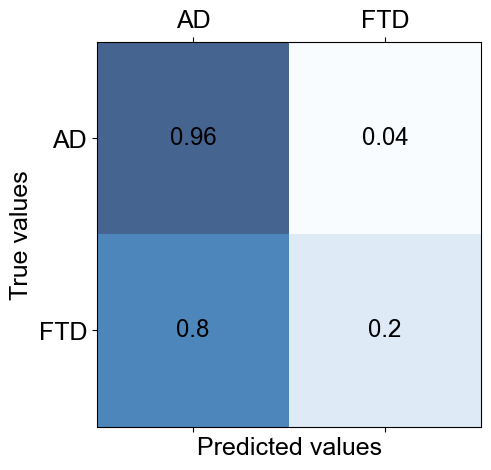

In [34]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'])

### RF Model

##### Bootstrap

In [35]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=5,
                       min_samples_leaf=0.01, min_samples_split=0.01,
                       n_estimators=500, n_jobs=-1)


Iterating: 100%|████████████████| 5000/5000 [1:20:07<00:00,  1.04it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:80.1316108306249 minutes
empirical p-value: 0.0


In [36]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2024-01-09/mean_res'

In [37]:
Model_res.to_csv(path_res+ "/RandomForest_Cog/Model_res.csv", index=False)
Model_res.mean()

Accuracy       0.806753
ROC_AUC        0.869145
Precision      0.571479
Recall         0.746104
Sensitivity    0.746104
Specificity    0.825477
F1             0.645627
Efron_pR2      0.241280
dtype: float64

In [38]:
print("%.4f" % Model_res['ROC_AUC'].mean())

0.8691


In [39]:
CI_df.to_csv(path_res+ "/RandomForest_Cog/CI_df.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.010945,0.009348,0.013717,0.012064,0.012064,0.010521,0.013258,0.01186


In [40]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest_Cog/Model_res_r.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
12,year_birth,0.290991,0.021241
5,ifs_total_score,0.238743,0.020274
1,cognition,0.113744,0.013333
13,years_education,0.090789,0.012595
9,npi_total,0.039143,0.004871
3,household_income,0.033926,0.005865
6,marital_status,0.033632,0.005535
2,functionality,0.033551,0.004015
8,n_children,0.031278,0.004939
10,npi_total_caregiver,0.026901,0.004991


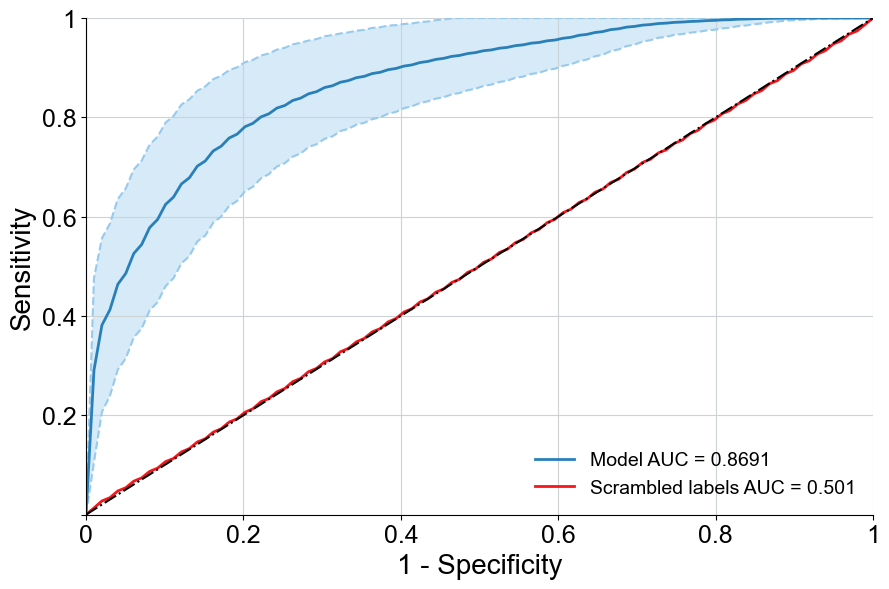

In [41]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest_Cog/ROC_AUC_curve.png")
# Fig save?


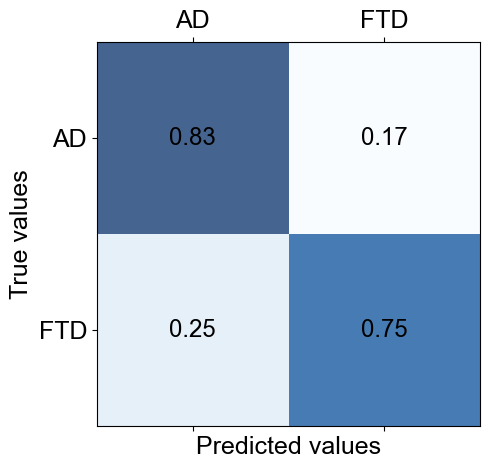

In [42]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest_Cog/CM.png")

##### Permutation Feature importance

In [43]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [44]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest_Cog/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

In [45]:
top_10p.head()

,predictor,mean,std
0,year_birth,0.119451,0.027873
3,ifs_total_score,0.103879,0.020301
7,cognition,0.031168,0.009282
2,years_education,0.026933,0.007214
6,npi_total_caregiver,0.010932,0.003274


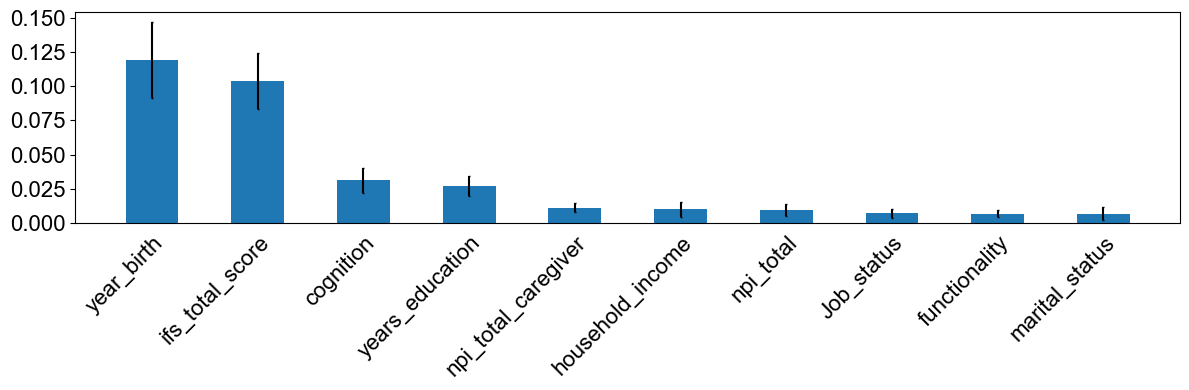

In [46]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

In [47]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
12,year_birth,0.290991,0.021241
5,ifs_total_score,0.238743,0.020274
1,cognition,0.113744,0.013333
13,years_education,0.090789,0.012595
9,npi_total,0.039143,0.004871


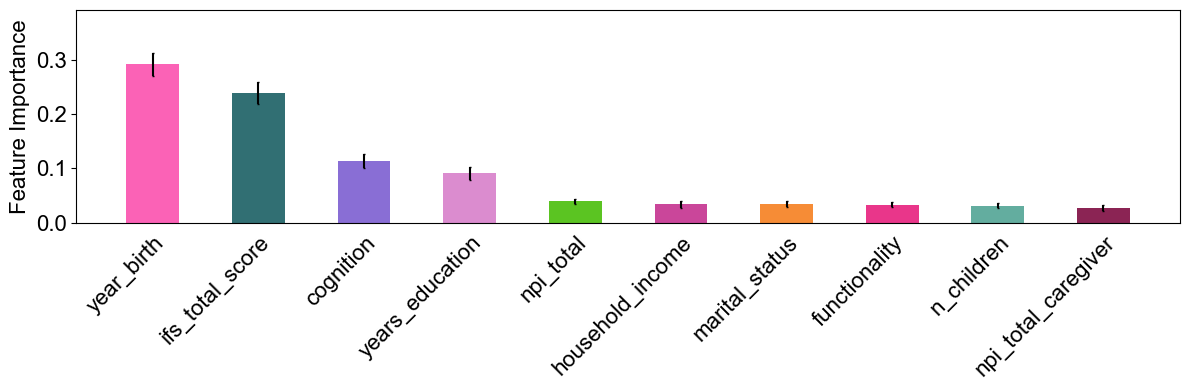

In [48]:
top_10 = Model_res_r.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [49]:
# X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
# X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [50]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [51]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")
unseen_df

,ROC AUC,Accuracy,Sensitivity,Recall,F1,Precision
0,0.839,0.8598,0.878049,0.8,0.7273,0.6667


In [52]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.839
Accuracy: 0.8598
Recall: 0.8
F1: 0.7273
Precision:0.6667


In [53]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.839
Bootstrping test ROC score: 	0.8691


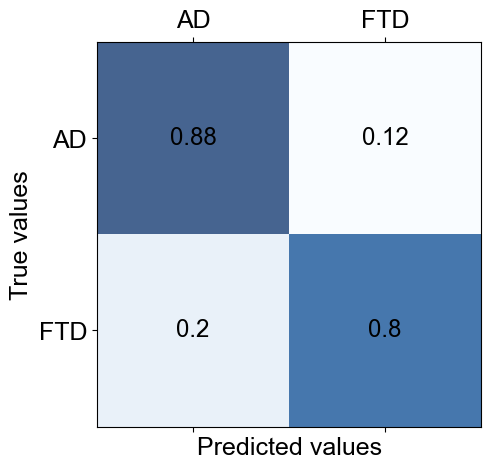

In [54]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'])

#### Shapley

In [55]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


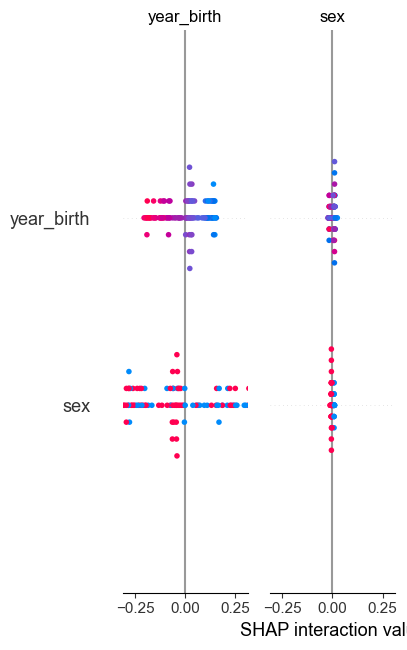

In [56]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

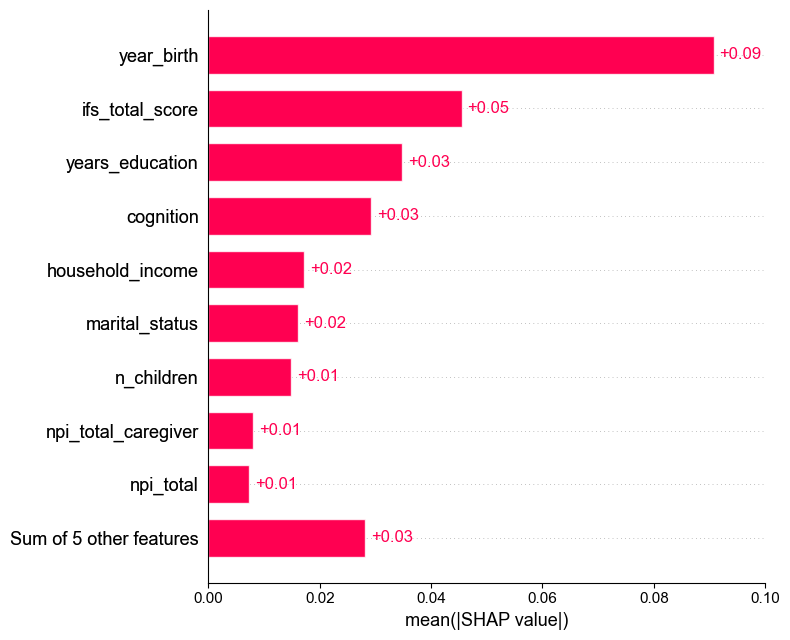

In [57]:
shap.plots.bar(shap_values[:,:,1])

In [58]:
# shap.plots.beeswarm(shap_values[:,:,1])

In [59]:
# # compute SHAP values
# explainer2 = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist())
# shap_values2 = explainer(X_test, check_additivity=False)

In [60]:
# shap.summary_plot(shap_values2[:,:,1])

In [61]:
# shap.plots.bar(shap_values2[:,:,1])

In [62]:

# # Convertir shap_values en un DataFrame
# shap_df = pd.DataFrame(shap_values, columns=X_train.columns.tolist())

# # Guardar el DataFrame en un archivo CSV
# shap_df.to_csv('shap_values.csv', index=False)


In [63]:
# shap_values2[:,:,1]

### Sequential feature selector

#### RF

In [64]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [65]:
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits)

In [66]:
rf_params

{'n_estimators': 500,
 'criterion': 'gini',
 'max_depth': 6,
 'min_samples_split': 0.01,
 'min_samples_leaf': 0.01,
 'max_features': 5,
 'class_weight': 'balanced',
 'verbose': 0,
 'n_jobs': -1}

In [67]:
rf_params['max_features'] =1

In [68]:
sfs_rfc = SFS(RandomForestClassifier(**rf_params), 
           k_features='best', 
           forward=False, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [69]:
sfs_rfc = sfs_rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    3.3s finished
Features: 13/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    3.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    3.6s finished
Features: 12/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    3.3s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.4s finished
Features: 11/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    3.1s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.2s finished
Features: 10/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 

In [70]:
sfs_rf = pd.DataFrame.from_dict(sfs_rfc.get_metric_dict()).T

In [71]:
sfs_rf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
14,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)","[0.7846153846153846, 0.7846153846153846, 0.793...",0.78748,"(year_birth, sex, years_education, ifs_total_s...",0.009117,0.004051,0.002865
13,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13)","[0.7876923076923077, 0.8, 0.8024691358024691]",0.79672,"(year_birth, sex, years_education, ifs_total_s...",0.014544,0.006463,0.00457
12,"(0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13)","[0.7938461538461539, 0.7907692307692308, 0.820...",0.801868,"(year_birth, sex, years_education, ifs_total_s...",0.030555,0.013578,0.009601
11,"(0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 13)","[0.7938461538461539, 0.8123076923076923, 0.820...",0.809047,"(year_birth, sex, years_education, ifs_total_s...",0.025469,0.011318,0.008003
10,"(0, 1, 2, 3, 5, 6, 7, 9, 11, 13)","[0.7846153846153846, 0.8092307692307692, 0.830...",0.808031,"(year_birth, sex, years_education, ifs_total_s...",0.041965,0.018648,0.013186
9,"(0, 1, 2, 3, 6, 7, 9, 11, 13)","[0.7753846153846153, 0.8123076923076923, 0.836...",0.808037,"(year_birth, sex, years_education, ifs_total_s...",0.056483,0.0251,0.017748
8,"(0, 1, 2, 3, 6, 7, 9, 11)","[0.7815384615384615, 0.8092307692307692, 0.836...",0.809063,"(year_birth, sex, years_education, ifs_total_s...",0.05042,0.022406,0.015843
7,"(0, 1, 2, 3, 6, 7, 9)","[0.7630769230769231, 0.8215384615384616, 0.814...",0.79981,"(year_birth, sex, years_education, ifs_total_s...",0.058776,0.026119,0.018469
6,"(1, 2, 3, 6, 7, 9)","[0.7630769230769231, 0.8092307692307692, 0.817...",0.796736,"(sex, years_education, ifs_total_score, npi_to...",0.054149,0.024063,0.017015
5,"(1, 3, 6, 7, 9)","[0.7692307692307693, 0.8276923076923077, 0.811...",0.802884,"(sex, ifs_total_score, npi_total_caregiver, co...",0.055522,0.024673,0.017446


In [72]:
sfs_rf.loc[[4],:]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
4,"(1, 3, 6, 9)","[0.8215384615384616, 0.8123076923076923, 0.805...",0.813134,"(sex, ifs_total_score, npi_total_caregiver, ma...",0.014742,0.006551,0.004632


In [73]:
# 5, 13
sfs_rf_features = list(sfs_rf.loc[4, 'feature_names'])

In [74]:
sfs_rf_features

['sex', 'ifs_total_score', 'npi_total_caregiver', 'marital_status']

In [75]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

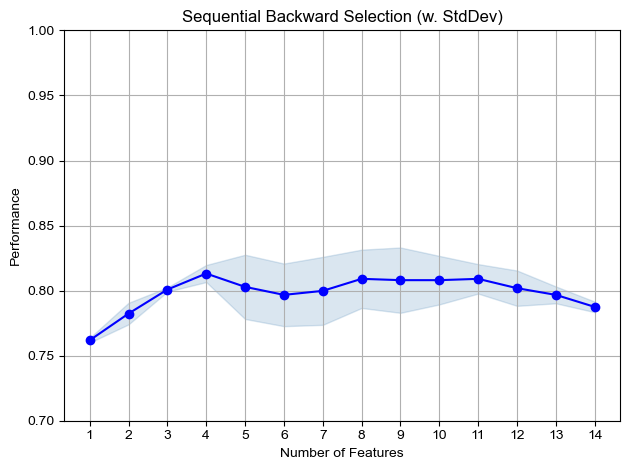

In [76]:
fig1 = plot_sfs(sfs_rfc.get_metric_dict(), kind='std_dev')


plt.ylim([0.7, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

### Shapley

In [77]:
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


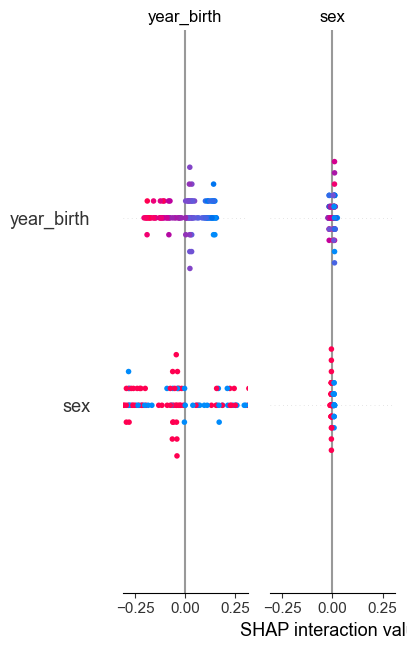

In [78]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

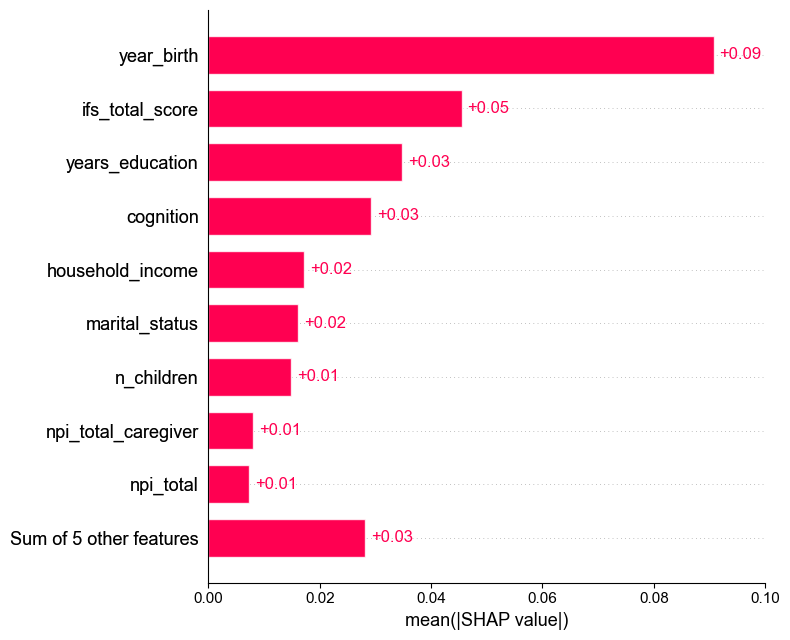

In [79]:
shap.plots.bar(shap_values[:,:,1])